<h1><font color='#030056'><center>Covid Detection via CT Scan Image Analysis</center></font></h1>

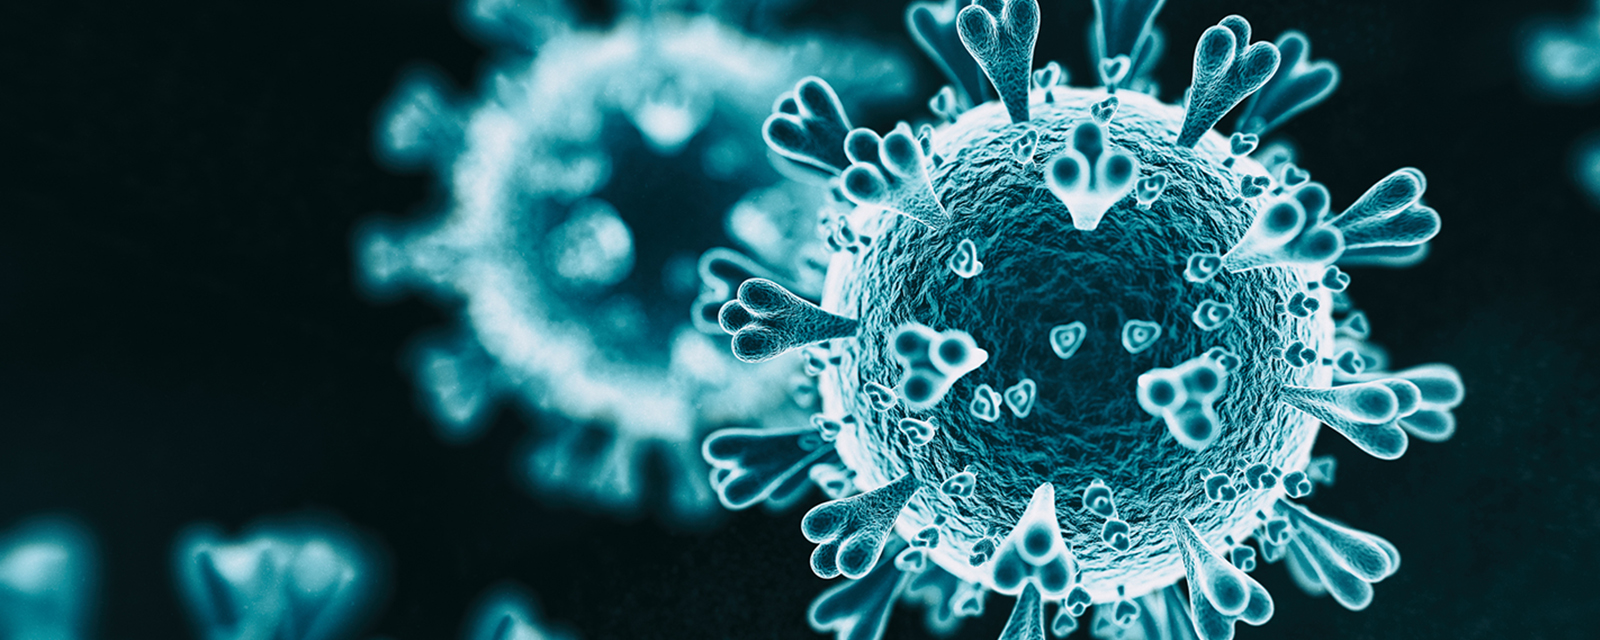

In [25]:
display(_image(filename="covid_19.jpg"))

<h2><font color='#030056'> Executive Summary </font></h2>

<p style="text-align:justify">Two years after the first infection of the disease, COVID-19 remains one of the most pressing and concerning diseases that is affecting our daily lives. At present, a lot of data have already been generated and collected from the patients and medical institutions concerning the disease. This study aims to utilize both machine and big data to create possible insights and preliminary descriptive analysis that may help in the generating data driven medical assessments.</p>

<p style="text-align:justify">CT-Scan images were processed and filtered using open lung layers to represent a CT-scan image collection. Selected layers were then processed and masked to isolate the lung and vessels portion of the image. These masks were then used to check area ratios comparing how prominent the detected vessels were relative to the lung area. SIFT was also performed to extract features from the images and matching was done between members of the same classification. And finally, a simple CNN was trained using the layers as input in trying to classify as infected or healthy.</p>

<p style="text-align:justify">Image processing and masking showed that although it cannot be generalized, covid-positive cases tend to have higher vessel (or lesion) to lung area ratio compared to healthy lungs. Feature detection and matching algorithm such as SIFT helped determine the features of the images and found out that there more features matched in the healthy CT-scan images. And lastly, neural networks trained to classify the selected images got a validation accuracy of 80%.</p>

<p style="text-align:justify">For future studies, the machine learning models could still be improved by changing its architecture design and applying data augmentation techniques on the dataset to increase the generalizability of the model. The use of more images or more representative slices could also be used to gather more information. Other methods of  image segmentation could also be explored.</p>

In [2]:
# Import libraries
import os
import cv2
import glob
import csv
import shutil
import pickle
import numpy as np
import seaborn as sns
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
import tensorflow as tf
from tensorflow import keras
from keras import layers
from lime import lime_image
from sklearn.model_selection import train_test_split


from PIL import Image, ImageDraw
from scipy.spatial import ConvexHull
from skimage import measure
from tqdm import tqdm
from IPython.display import HTML
from IPython.display import Image as _image
from skimage.segmentation import mark_boundaries

tqdm.pandas()

# constants
COVID_COLORS = ['#030056', '#2e2e99']

# load redacted file paths
with open('REDACTED_FILE_PATH.txt', 'r') as f:
    file_paths = f.readlines()
    
file_paths = [i.strip() for i in file_paths]

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<style>
.output_png {
    display: table-cell;
    text-align: center;
    horizontal-align: middle;
    vertical-align: middle;
    margin:auto;
}

tbody, thead {
    margin-left:100px;
}

</style>
<form action="javascript:code_toggle()"><input type="submit"
value="Click here to toggle on/off the raw code."></form>''')

In [3]:
# some functions modified from reference [6]
def show_slice(slice):
    '''
    Display an image slice
    '''
    plt.figure()
    plt.imshow(slice.T, cmap="gray", origin="lower")

def show_slice_window(slice, level, window):
    '''
    Display an image slice with level and window filter
    '''
    max = level + window/2
    min = level - window/2
    slice = slice.clip(min,max)
    plt.figure()
    plt.imshow(slice.T, cmap="gray", origin="lower")
    plt.savefig('L'+str(level)+'W'+str(window))

def overlay_plot(im, mask, overlay_name):
    '''
    Display plots
    '''
    plt.figure()
    plt.imshow(im.T, 'gray', interpolation='none')
    plt.imshow(mask.T, 'jet', interpolation='none', alpha=0.5)
    plt.savefig(overlay_name)

def intensity_seg(ct_numpy, min, max):
    '''
    Used for image clipping.
    '''
    clipped = ct_numpy.clip(min, max)
    clipped[clipped != max] = 1
    clipped[clipped == max] = 0
    return measure.find_contours(clipped, 0.95)

def set_is_closed(contour):
    if contour_distance(contour) < 1:
        return True
    else:
        return False

def find_lungs(contours):
    '''
    Chooses the contours that correspond to the lungs and the body
    '''
    body_and_lung_contours = []
    vol_contours = []

    for contour in contours:
        hull = ConvexHull(contour)

        if hull.volume > 2000 and set_is_closed(contour):
            body_and_lung_contours.append(contour)
            vol_contours.append(hull.volume)

    if len(body_and_lung_contours) == 2:
        return body_and_lung_contours
    elif len(body_and_lung_contours) > 2:
        (vol_contours, 
         body_and_lung_contours) = (list(t) 
                                    for t in 
                                    zip(*sorted(zip(vol_contours, 
                                                    body_and_lung_contours))))
        body_and_lung_contours.pop(-1)
        return body_and_lung_contours

def create_mask_from_polygon(image, contours):
    '''
    Creates a binary mask and merges them together
    '''
    lung_mask = np.array(Image.new('L', image.shape, 0))
    mask_check = []
    for contour in contours:
        x = contour[:, 0]
        y = contour[:, 1]
        polygon_tuple = list(zip(x, y))
        img = Image.new('L', image.shape, 0)
        ImageDraw.Draw(img).polygon(polygon_tuple, outline=0, fill=1)
        mask = np.array(img)
        if (mask.sum() > 2000):
            mask_check.append(mask)
            lung_mask += mask

    if (lung_mask.max() > 1) or (len(mask_check) < 2):
        return np.array([])
    else:
        return lung_mask.T

def save_nifty(img_np, name, affine):
    '''
    Save binary mask back to a nifty file
    '''
    img_np[img_np == 1] = 255
    ni_img = nib.Nifti1Image(img_np, affine)
    nib.save(ni_img, name + '.nii')

def find_pix_dim(ct_img):
    '''
    Get the pixel dimension of the CT image.
    '''
    pix_dim = ct_img.header["pixdim"]
    dim = ct_img.header["dim"]
    max_indx = np.argmax(dim)
    pixdimX = pix_dim[max_indx]
    dim = np.delete(dim, max_indx)
    pix_dim = np.delete(pix_dim, max_indx)
    max_indy = np.argmax(dim)
    pixdimY = pix_dim[max_indy]
    return [pixdimX, pixdimY]

def contour_distance(contour):
    '''
    Calculates the distance between the first and the last point
    to infer if the set is closed.
    '''
    dx = contour[0, 1] - contour[-1, 1]
    dy = contour[0, 0] - contour[-1, 0]
    return np.sqrt(np.power(dx, 2) + np.power(dy, 2))

def compute_area(mask, pixdim):
    '''
    Computes the area of a binary mask and multiplies the pixels
    with the pixel dimension of the CT image
    '''
    mask[mask >= 1] = 1
    lung_pixels = np.sum(mask)
    return lung_pixels * pixdim[0] * pixdim[1]

def euclidean_dist(dx, dy):
    '''
    Measure euclidean distance
    '''
    return np.sqrt(np.power(dx, 2) + np.power(dy, 2))

def denoise_vessels(lungs, vessels):
    ''' 
    Denoise the vessels of the lungs
    '''
    vessels_coords_x, vessels_coords_y = np.nonzero(vessels)
    for contour in lungs:
        x_points, y_points = contour[:, 0], contour[:, 1]
        for (coord_x, coord_y) in zip(vessels_coords_x, vessels_coords_y):
            for (x, y) in zip(x_points, y_points):
                d = euclidean_dist(x - coord_x, y - coord_y)
                if d <= 0.1:
                    vessels[coord_x, coord_y] = 0
    return vessels

def split_array_coords(array, indx=0, indy=1):
    ''' Split coordinates of array
    '''
    x = [array[i][indx] for i in range(len(array))]
    y = [array[i][indy] for i in range(len(array))]
    return x, y


def create_vessel_mask(lung_mask, ct_numpy, lungs, denoise=False):
    '''
    Creates a mask for the vessel areas.
    '''
    vessels = lung_mask * ct_numpy  # isolate lung area
    vessels[vessels == 0] = -1000
    vessels[vessels >= -500] = 1
    vessels[vessels < -500] = 0
    #show_slice(vessels)
    if denoise:
        return denoise_vessels(lungs, vessels)

    return vessels

<h2><font color='#030056'> I. Introduction </font></h2>

<p style="text-align:justify">Coronavirus disease (COVID-19) is an infectious disease caused by the SARS-CoV-2 virus that started in 2019. Most people infected with the virus experienced mild to moderate fever, cough, respiratory illness and recover without undergoing any treatment. However, some will become seriously ill and require medical attention specially those that have medical conditions like cardiovascular disease, chronic respiratory disease, diabetes, or cancer $^1$. The most common cause of death affected by COVID-19 that accounts to 45 percent of the overall is refractory respiratory failure $^2$. </p>

<p style="text-align:justify">Chest X-ray and Computed Tomography scan (CT-Scan) are usually a method to identify any respiratory diseases. X-ray provides a 2D image, while a chest CT scan provide a 3D view that is able to capture more information such as bones, soft tissues, and blood vessels. </p>

<p style="text-align:justify">Anyone can get sick with COVID-19 and become seriously ill or die at any age. As Philippines started to loosen up their restrictions and enter to alert level 1$^3$, our health care services should still improve their capability and technology as we will never know if there will be new variant of COVID-19 or another source of pandemic.</p>


<b> Problem Statement </b>

<p style="text-align:justify">A lot of data was generated since the pandemic started specially from medical imaging processes. The challenge is to find other ways to make use of these available data in trying to generate new ways of data driven medical assessments. In this project, the researchers aim to answer <b>How might we detect COVID-19 via CT-Scan images?</b></p>

<b>Motivation</b>

<p style="text-align:justify">The presence of more powerful computing machines will aid in using available big data generated by the imaging processes, in particular CT-scan images. This study aims to utilize both machine and data to create possible insights and preliminary or descriptive analysis that may help in the study of this disease. It also aims to incorporate several techniques in image processing, feature extraction and machine learning into the process.</p>

<b>Disclaimer</b>

Don’t use this study for self-diagnosis without performing a clinical study and consulting with a medical specialist.

<h2><font color='#030056'> II. Methodology </font></h2>

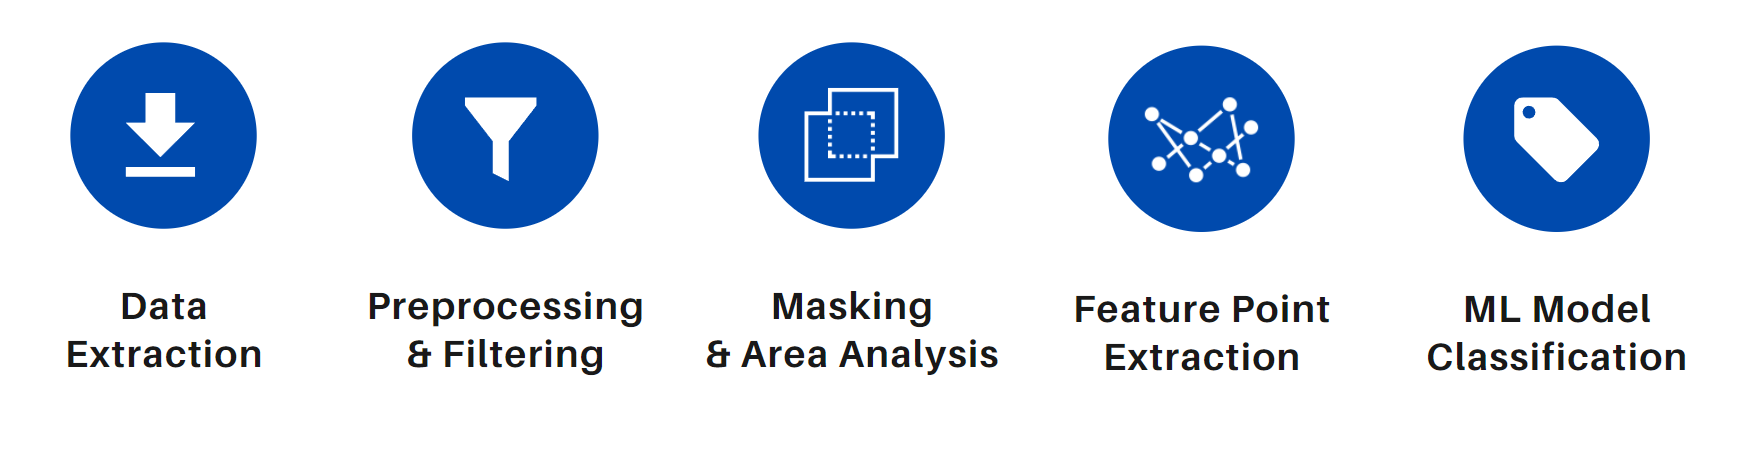

In [4]:
display(_image(filename="method.PNG"))

#### 1. Extraction of data from AWS Open Data.
<p style="text-align:justify">Used AWS cli to extract the InRad Data that were provided by were provided by Hospital das Clínicas da Universidade de São Paulo and store it in our AWS S3.</p>

#### 2. Preprocessing and Layer Filtering for Best Representation
<p style="text-align:justify">Images corresponding to healthy and covid-positive were chosen. Several preprocessing steps were used to determine which layer best represents the entire set of CT images per sample. Ultimately picking the largest lung area identified eliminating the possibility of using closed lung layers.</p>

#### 3. Image Masking and Area Computation
<p style="text-align:justify">The chosen representative layers were then subjected to image segmentation and binarization to create masks for both the lungs and the vessels. Area was computed for both and their ratios are used for analysis.</p>
    
#### 4. Feature Point Extraction.
<p style="text-align:justify">Descriptive analytics is performed by using SIFT to perform feature detection and matching of two images that belong to the same class such as COVID-19 positive and healthy CT-Scan.</p>

#### 5. Machine Learning Model Classification.
<p style="text-align:justify">Predictive analytics is performed by using simpe convolutional network trained from scratch with input of image with the largest lung area and outputs the probability of the possibility of being COVID-19 positive. We then used model explainability method such as LIME to undertand the behavior of the model.</p>

<h2><font color='#030056'> III. Data Processing </font></h2>

### A. Extract and Preprocess Dataset

<p style="text-align:justify">This dataset used is repository of anonymized computed tomography (CT) scans of people suspected to have COVID-19 infections. Images were labeled after confirmation from tests. The dataset is publicly available in the Open Data Registry from AWS and were provided by Hospital das Clínicas da Universidade de São Paulo, Hospital Sirio-Libanes, and by Laboratory Fleury.</p>

<p style="text-align:justify">Images were in .nii format also know as NIfTI is mostly used for multi-dimensional data, most often in neuroimaging. These files could contain up to a maximum of 7 channels, most commonly the spatial dimesions, but could also include a time or channels. In our dataset's case, there are 3 dimensions and are they are all corresponding to spatial dimensions.</p>

<p style="text-align:justify">The specific images (Chest CT Scan Images) from the open data bucket were transfered to our team's S3 bucket where a total of 1294 nifty images were transfered. Only images with labels healthy and covid-positive will be used for the purpose of the study.</p>

### B. Data Description

<p style="text-align:justify">Aside from the actual CT-Scan images, we used a csv file that contains the filename and the classification type of the 1294 data points which can be seen in more detail in the table:</p>


<center style="font-size:12px;font-style:default;"><b>Table 1  Table Feature Names, Types and Descriptions</b></center>

| Feature Name | Data Type | Description |
| :- | :- | :- |
| image_id | str | file name of the image |
| type | int | 0: healthy; 1: other diseases; 2: covid-19 positive |

The total size of the dataset is 253.2 GB as seen from the bucket folder scan below:

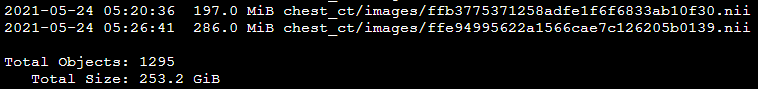

In [5]:
display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 1. Initial Data Size Scan.
</b></center>'''))

display(_image(filename="totalsize.PNG"))

### C. AWS configuration

<p style="text-align:justify">A 4-instance EMR cluster was prepared for this study which includes 1 master and 3 core instances. The latest EMR release was used (6.5.0). The machines used are all m5.xlarge nodes with 4 cores, 16 GB memory each and EBS storage of 64GB. The EBS root volume size was set to 100 GB.<p>

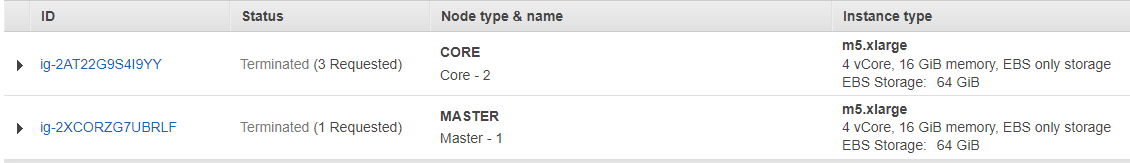

In [6]:
display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 2. AWS Cluster Configuration.
</b></center>'''))

display(_image(filename="instances.PNG"))

<h2><font color='#030056'> IV. Exploratory Data Analysis </font></h2>

In [7]:
# load filtered data
with open('data/data_full_df.pkl', 'rb') as f:
    data_full = pickle.load(f)

### A. Distribution of COVID-19 and Healthy CT Scan

Let us first take a look on the distribution of our dataset which can be classified as COVID-19 positive or a healthy CT-Scan lungs.

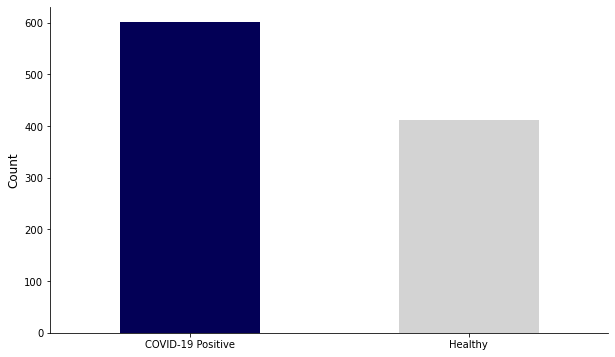

In [8]:
df = pd.read_csv(file_paths[0])
# drop ct scan with other diseases
df = df[df.type != 1]
df.loc[df.type == 2, 'type'] = 'COVID-19 Positive'
df.loc[df.type == 0, 'type'] = 'Healthy'

display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 3. Distribution of dataset.
</b></center>'''))

display(HTML(f'''<h3 style="text-align:center">
                There are more 
                <b style="color:{COVID_COLORS[1]}">
                COVID-19 Positive</b> in our dataset
                </h3>'''))

plt.figure(figsize=(10, 6))
df.type.value_counts().plot.bar(color=[COVID_COLORS[0],'lightgray']);


plt.ylabel("Count", fontsize=12)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=0)
plt.show()

The distribution of data in our dataset seems to be somehow balanced with a little more on COVID-19 positive.

### B. Window & Layer Adjustment

<p style="text-align:justify">Tissue density is measured and represented by the Hounsfield scale, which has a zero value corresponding to water's density. Any tissue denser have positive values while less dense tissues have negative values. Low values are represented by darker colors in images and denser materials are represented as lighter colors. Housefield values range from -1000 to 1000 and usual visualization libraries usually use 0-255 scales. For these instances, clipping the Housefield range is the usual method used. The image is clipped based on a set level and window/range value.</p>

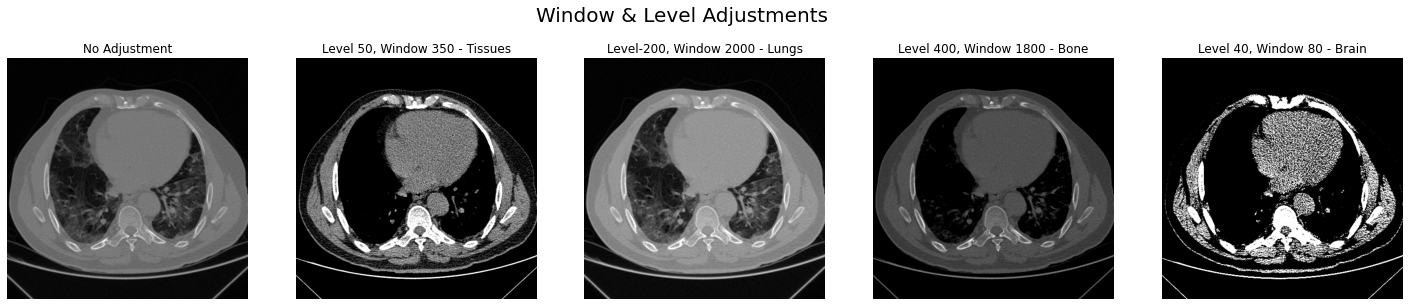

In [9]:
ct_numpy = data_full.loc[data_full['image_id'] == 
                         'f1307eb3c73af8ef7305a9825628deaf', 'img'].iloc[0]

display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 4. Effects of Level and Window Adjustments in CT-Scan Images.
</b></center>'''))

fig, ax = plt.subplots(1, 5, figsize=(25,5))
fig.suptitle('Window & Level Adjustments', fontsize=20)
ax = ax.flatten()

ax[0].imshow(ct_numpy.T, cmap="gray", origin="lower")
ax[0].axis('off')
ax[0].set_title('No Adjustment')

level = 50
window = 350
max = level + window/2
min = level - window/2
ct_numpy1 = ct_numpy.clip(min,max)
ax[1].imshow(ct_numpy1.T, cmap="gray", origin="lower")
ax[1].axis('off')
ax[1].set_title('Level 50, Window 350 - Tissues')

level = -200
window = 2000
max = level + window/2
min = level - window/2
ct_numpy2 = ct_numpy.clip(min,max)
ax[2].imshow(ct_numpy2.T, cmap="gray", origin="lower")
ax[2].axis('off')
ax[2].set_title('Level-200, Window 2000 - Lungs')

level = 400
window = 1800
max = level + window/2
min = level - window/2
ct_numpy3 = ct_numpy.clip(min,max)
ax[3].imshow(ct_numpy3.T, cmap="gray", origin="lower")
ax[3].axis('off')
ax[3].set_title('Level 400, Window 1800 - Bone')


level = 40
window = 80
max = level + window/2
min = level - window/2
ct_numpy4 = ct_numpy.clip(min,max)
ax[4].imshow(ct_numpy4.T, cmap="gray", origin="lower")
ax[4].axis('off')
ax[4].set_title('Level 40, Window 80 - Brain');

<p style="text-align:justify">The images above are from the same CT scan image but with different window and level values used in order to emphasize some of the parts. Soft tissues (2), lungs (3) and bones (4) configurations each show a different image biased towards what is intended to be highlighted.</p>

### C. Layer by Layer Comparison of COVID-19 and Healthy CT Scan

<p style="text-align:justify">We looked into the different slices of chest CT-Scan. We loaded two chest CT-Scan, a COVID-19 positive and a healthy CT-Scan. We fist checked the shapes of each file.</p>

In [10]:
clean_img = nib.load(file_paths[1])
print('Healthy CT-Scan')
print('Image Affine shape: ', clean_img.affine.shape)

clean_img = clean_img.get_fdata()
height, width, depth = clean_img.shape
print('Image shape: ', clean_img.shape)

Healthy CT-Scan
Image Affine shape:  (4, 4)
Image shape:  (512, 512, 441)


In [11]:
covid_img = nib.load(file_paths[2])
print('COVID-19 CT-Scan')
print('Image Affine shape: ', covid_img.affine.shape)

covid_img = covid_img.get_fdata()
height, width, depth = covid_img.shape
print('Image shape: ', covid_img.shape)

COVID-19 CT-Scan
Image Affine shape:  (4, 4)
Image shape:  (512, 512, 572)


The shape of the images are both have width and length of 512 but have different number of slices. This is expected since a human body can be larger or smaller depending on the person.

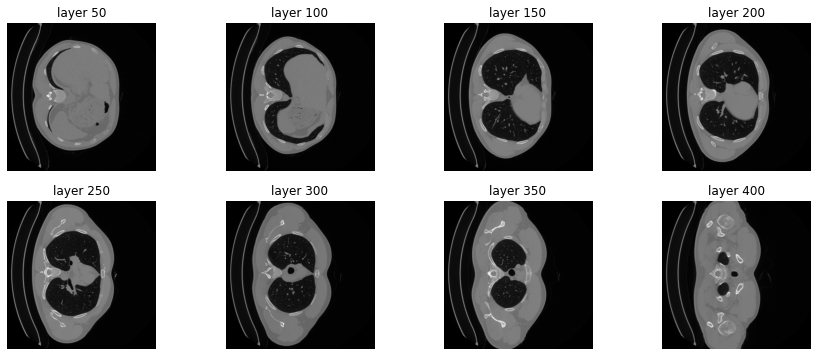

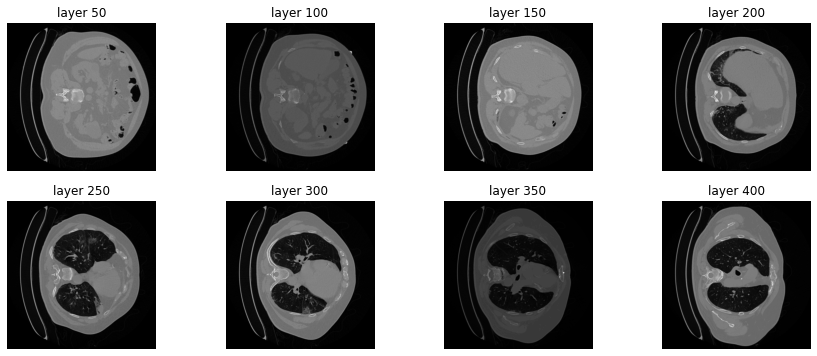

In [12]:
display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 5. Layer-by-layer comparison of COVID-19 and Healthy CT-Scan.
</b></center>'''))

display(HTML(f'''<h3 style="text-align:center">
                <b style="color:{COVID_COLORS[1]}">
                Clean</b> layer-by-layer CT-scan
                </h3>'''))

fig, ax = plt.subplots(2, 4, figsize=(15,6))
ax = ax.flatten()

for i in range(1, 9):
    layer = i * 50 
    ax[i-1].imshow(clean_img[:, :, layer], cmap='gray')
    ax[i-1].set_title(f'layer {layer}')
    ax[i-1].axis('off')
plt.show()

display(HTML(f'''<h3 style="text-align:center">
                <b style="color:{COVID_COLORS[1]}">
                COVID-19</b> layer-by-layer CT-scan
                </h3>'''))

fig, ax = plt.subplots(2, 4, figsize=(15,6))
ax = ax.flatten()

for i in range(1, 9):
    layer = i * 50 
    ax[i-1].imshow(covid_img[:, :, layer], cmap='gray')
    ax[i-1].set_title(f'layer {layer}')
    ax[i-1].axis('off')
plt.show()

<p style="text-align:justify">We observed that each layer does not correspond to the same layer in another CT-Scan due to the difference in the body structure of a person. We can also se that there is no significant difference when the lungs is not visible in the CT-Scan. Lastly, we can see that there are some lesions on the lungs of the COVID-19 positive.</p>

<h2><font color='#030056'> V. Results and Discussion </font></h2>

<p style="text-align:justify">The next step is to find the representative layer per nifty image, which will be used for further analysis. Since the layers correspond to cross-sectional representations of the body, the ideal layer to be used would be the instance where the largest lung area is present. To add to the complexity of CT scan images, it should also be noted that there is a possibility of capturing an open or closed lung during the scan due to the test subject breathing.</p>

### A. Open vs Closed Lungs Filtering

<p style="text-align:justify">Found below are two layers coming from a scan image of a single person. The first layer, mostly filled with gray pixels is a representation of closed lungs meanwhile, the next photos represents an open lung.</p>

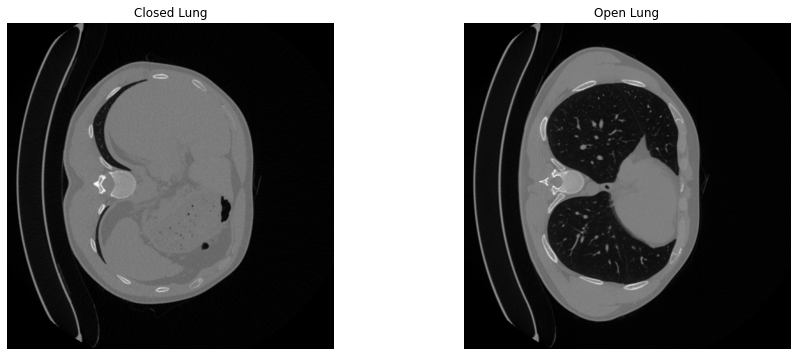

In [13]:
display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 6. Closed vs Open Lung Visualization.
</b></center>'''))

fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax = ax.flatten()

ax[0].imshow(clean_img[:, :, 50], cmap='gray')
ax[0].set_title('Closed Lung')
ax[0].axis('off')
    
ax[1].imshow(clean_img[:, :, 150], cmap='gray')
ax[1].set_title('Open Lung')
ax[1].axis('off')
    
plt.show()

<p style="text-align:justify">The idea is to be able to get the lung area, regardless of the state (open or closed) because anyway, the layer with the largest lung-area will be the representative of that particular image.</p>

### B. Lung & Vessel Area Extraction

<p style="text-align:justify">The initial step was to identify the contours of the lungs and the body and together with this compute the area the lung covers. The input images are binarized by clipping the image range [-1000, -300] and binarizing the values in to 0's an 1's. Then the countour was then found using the measure fuction of skimage. Below are the results of contour finding.</p>

In [14]:
# list of covid samples for figures
covid_plotlist = ['e3469028160260b484382d453918ad37',
'949cb3cb4cd8a861d4db9ea42a242bdc',
'c97d4883b8db63afceaab6e121d7f6a4',
'e398f95375685aac4ffffbefa46d1750',
'f724366aef214458b33257368a6a8455',
'd80f0ac3ab1aaf5fea2c8d632d1da620',
'116b498b1b28e02aab2dfe7e1bae16f0',
'1aa1f48afee83ff939b785aa33d40e37',
'f1307eb3c73af8ef7305a9825628deaf',
'70b1eaaa82610607557d4c75c2d85c12',]

# list of clean samples for figures
clean_plotlist = ['61cfe20015eb511fd1d7d6ba97d1f025',
'ab54f35280cf99ed17d1609d0ab41a16',
'82fd4923e699af68957f4c233225cc3f',
'1cfb76e7c1c2c34e5a511df6c57a0bda',
'73e9781777f5caad2b05b80e700d2495',
'694e9d7dfa9e15359f093b4aad391baf',
'6a5ebe62757be6a3a3406e2d5b834718',
'583736e02e311ea0489e9acffbd07177',
'ab85a0c259a9544dc20c2373f53ac49f',
'7bb157ebb36aac5ec4d16412b5650591']

#### Lung Area Outlines

<p style="text-align:justify">Here are 10 sample images for both covid-positive and healthy people where the outlines of the clusters formed are shown. Most of the time, it records 2 as the lung count.<p>

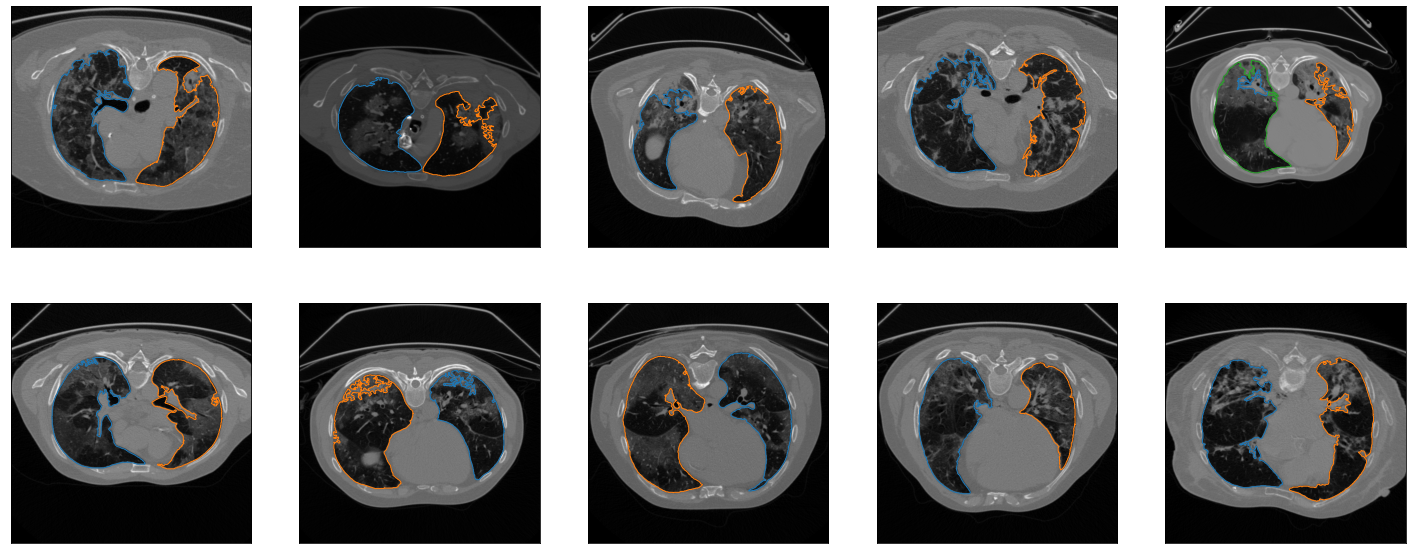

In [15]:
display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 7. Lung Area Outlines - Covid
</b></center>'''))

fig, ax = plt.subplots(2, 5, figsize=(25,10))
ax = ax.flatten()

for i, filename in enumerate(covid_plotlist):
    img_name = filename
    
    ct_numpy = data_full.loc[data_full['image_id'] == filename, 'img'].iloc[0]
    ct_img = nib.Nifti1Image(ct_numpy, affine=np.eye(4))
    pixdim = find_pix_dim(ct_img)
    
    contours = intensity_seg(ct_numpy, min=-1000, max=-300)
    lungs = find_lungs(contours)
    
    ax[i].imshow(ct_numpy.T, cmap=plt.cm.gray)
    for contour in lungs:
        ax[i].plot(contour[:, 0], contour[:, 1], linewidth=1)
    
    ax[i].set_xticks([])
    ax[i].set_yticks([])

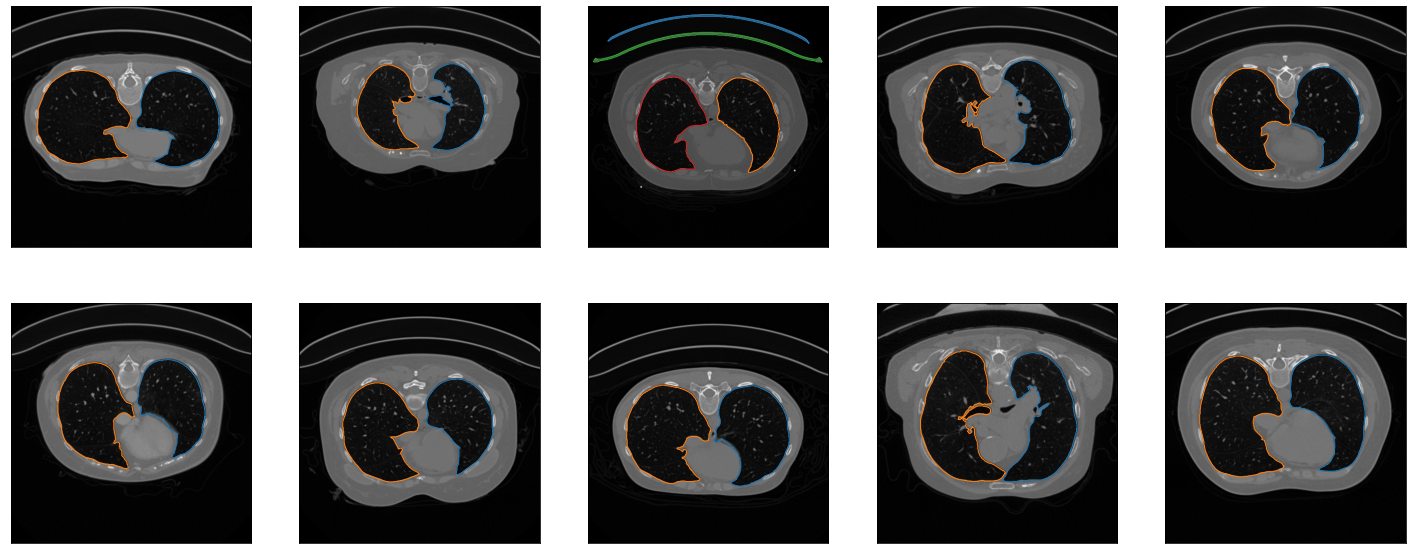

In [16]:
display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 8. Lung Area Outlines - Normal
</b></center>'''))

fig, ax = plt.subplots(2, 5, figsize=(25,10))
ax = ax.flatten()

for i, filename in enumerate(clean_plotlist):
    img_name = filename
    
    ct_numpy = data_full.loc[data_full['image_id'] == filename, 'img'].iloc[0]
    ct_img = nib.Nifti1Image(ct_numpy, affine=np.eye(4))
    pixdim = find_pix_dim(ct_img)
    
    contours = intensity_seg(ct_numpy, min=-1000, max=-300)
    lungs = find_lungs(contours)
    
    ax[i].imshow(ct_numpy.T, cmap=plt.cm.gray)
    for contour in lungs:
        ax[i].plot(contour[:, 0], contour[:, 1], linewidth=1)

    ax[i].set_xticks([])
    ax[i].set_yticks([])

#### Lung Area Masks

<p style="text-align:justify">Contours are then converted to binary format and saved as masks. Visually, masks for the healthy images look more whole compared to the lung masks from the covid positive samples.</p>

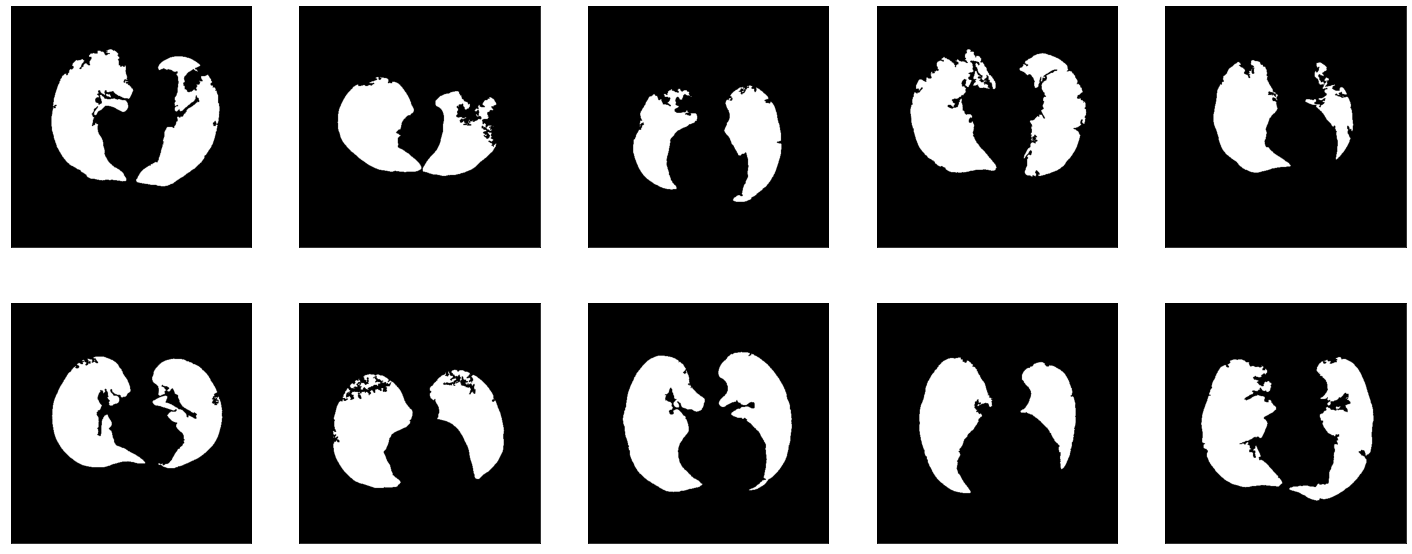

In [17]:
display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 9. Lung Mask - Covid
</b></center>'''))

fig, ax = plt.subplots(2, 5, figsize=(25,10))
ax = ax.flatten()

for i, filename in enumerate(covid_plotlist):
    img_name = filename
    
    ct_numpy = data_full.loc[data_full['image_id'] == filename, 'img'].iloc[0]
    ct_img = nib.Nifti1Image(ct_numpy, affine=np.eye(4))
    pixdim = find_pix_dim(ct_img)
    
    contours = intensity_seg(ct_numpy, min=-1000, max=-300)
    
    lungs = find_lungs(contours)
    lung_mask = create_mask_from_polygon(ct_numpy, lungs)
    
    lung_mask[lung_mask == 1] = 255
    lungs_img = nib.Nifti1Image(lung_mask, ct_img.affine)
    lungs_numpy = lungs_img.get_fdata()
    ax[i].imshow(lungs_numpy.T, cmap='gray')
    
    ax[i].set_xticks([])
    ax[i].set_yticks([])

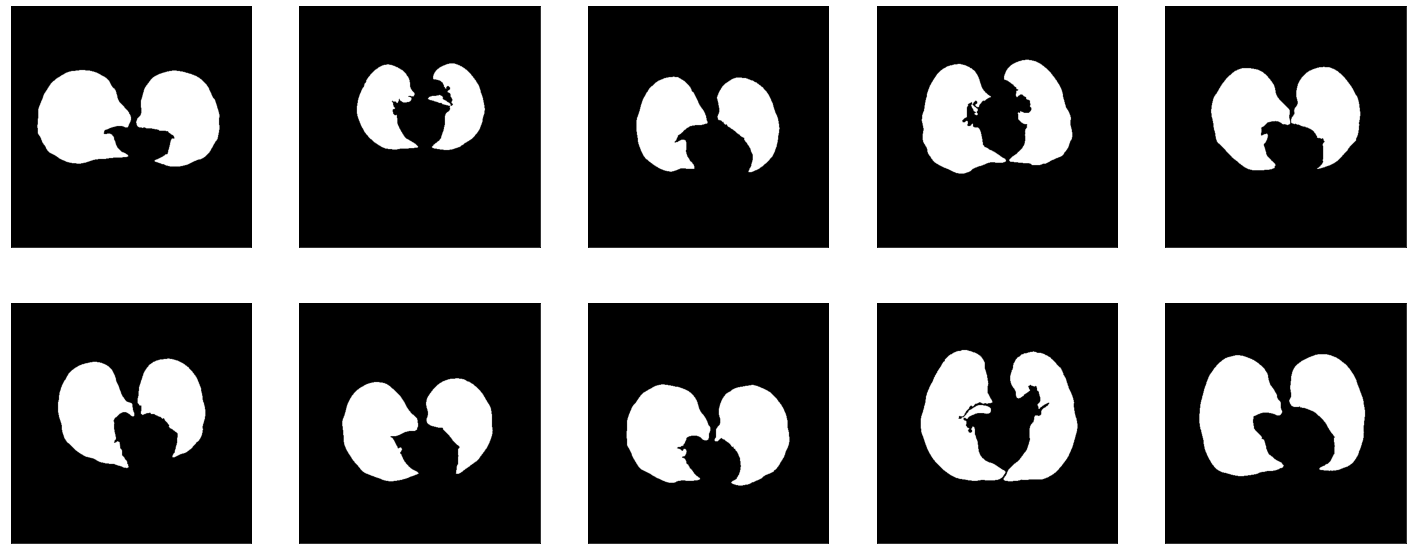

In [18]:
display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 10. Lung Mask - Normal
</b></center>'''))

fig, ax = plt.subplots(2, 5, figsize=(25,10))
ax = ax.flatten()

for i, filename in enumerate(clean_plotlist):
    img_name = filename
    
    ct_numpy = data_full.loc[data_full['image_id'] == filename, 'img'].iloc[0]
    ct_img = nib.Nifti1Image(ct_numpy, affine=np.eye(4))
    pixdim = find_pix_dim(ct_img)
    
    contours = intensity_seg(ct_numpy, min=-1000, max=-300)
    
    lungs = find_lungs(contours)
    lung_mask = create_mask_from_polygon(ct_numpy, lungs)
    
    lung_mask[lung_mask == 1] = 25
    lungs_img = nib.Nifti1Image(lung_mask, ct_img.affine)
    lungs_numpy = lungs_img.get_fdata()
    ax[i].imshow(lungs_numpy.T, cmap='gray')

    ax[i].set_xticks([])
    ax[i].set_yticks([])

#### Vessels Area Masks

<p style="text-align:justify">The next target are the vessels which could be isolated by initially doing an element-wise multiplication between the CT image and the lung mask that was produced in the previous step. This will enable us to get only the lung part of the image. Then it will be binarized as well by keeping values higher than -500 as 1 and those below it as zero. Sample vessel masks are seen below and noticeable bigger vessel areas are found in covid-positive images, but not always.</p>

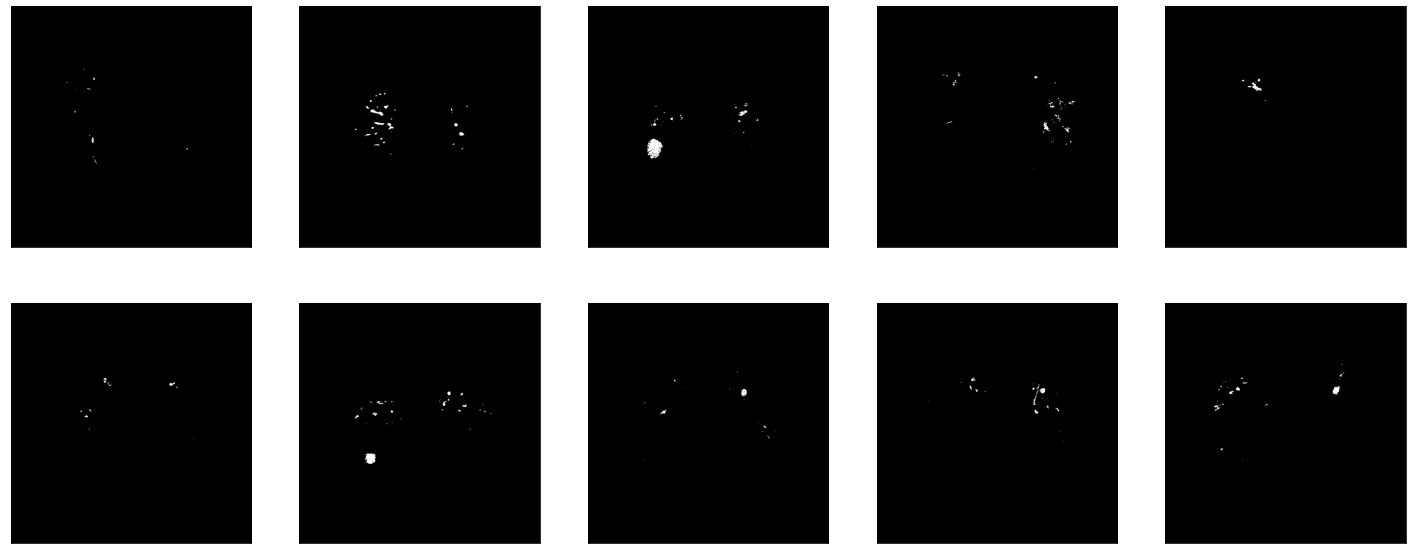

In [19]:
display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 11. Vessel Mask - Covid
</b></center>'''))

fig, ax = plt.subplots(2, 5, figsize=(25,10))
ax = ax.flatten()

for i, filename in enumerate(covid_plotlist):
    img_name = filename
    
    ct_numpy = data_full.loc[data_full['image_id'] == filename, 'img'].iloc[0]
    ct_img = nib.Nifti1Image(ct_numpy, affine=np.eye(4))
    pixdim = find_pix_dim(ct_img)
    
    contours = intensity_seg(ct_numpy, min=-1000, max=-300)
    
    lungs = find_lungs(contours)
    lung_mask = create_mask_from_polygon(ct_numpy, lungs)
    
    lung_mask[lung_mask == 1] = 255
    lungs_img = nib.Nifti1Image(lung_mask, ct_img.affine)

    vessels_only = create_vessel_mask(lung_mask, ct_numpy, lungs, 
                                      denoise=True)
    
    vessels_only[vessels_only == 1] = 255
    vessel_img = nib.Nifti1Image(vessels_only, ct_img.affine)
    vessel_numpy = vessel_img.get_fdata()
    ax[i].imshow(vessel_numpy.T, cmap='gray')
    
    ax[i].set_xticks([])
    ax[i].set_yticks([])

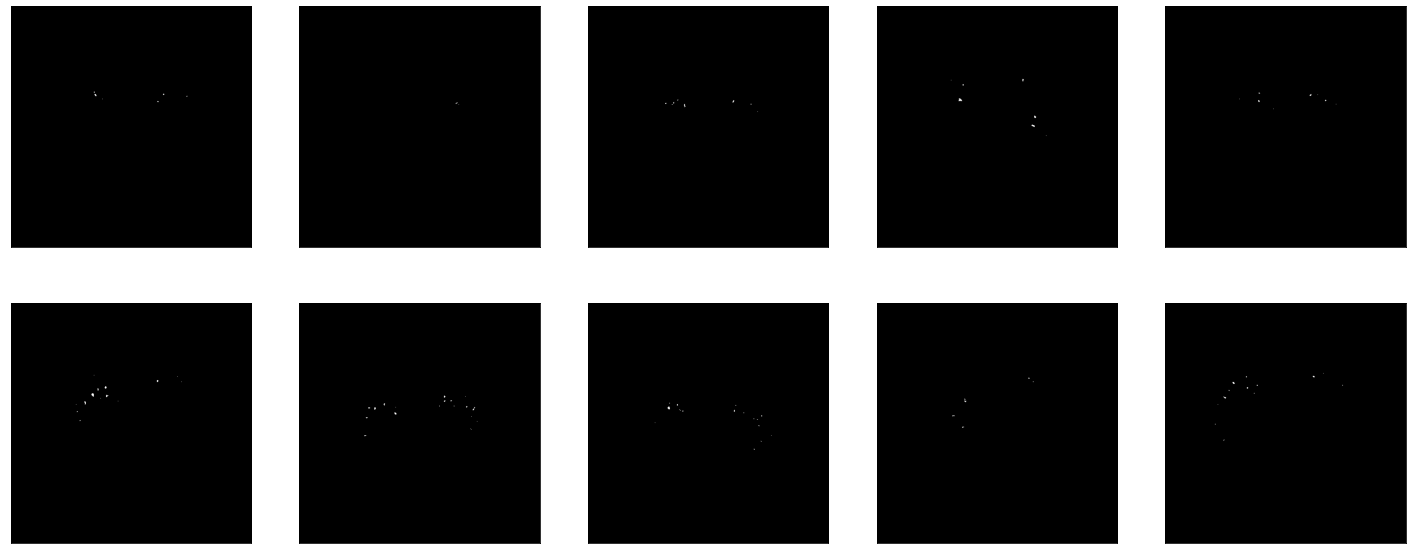

In [20]:
display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 12. Vessel Mask - Normal
</b></center>'''))

fig, ax = plt.subplots(2, 5, figsize=(25,10))
ax = ax.flatten()

for i, filename in enumerate(clean_plotlist):
    img_name = filename
    
    ct_numpy = data_full.loc[data_full['image_id'] == filename, 'img'].iloc[0]
    ct_img = nib.Nifti1Image(ct_numpy, affine=np.eye(4))
    pixdim = find_pix_dim(ct_img)
    
    contours = intensity_seg(ct_numpy, min=-1000, max=-300)
    
    lungs = find_lungs(contours)
    lung_mask = create_mask_from_polygon(ct_numpy, lungs)
    
    lung_mask[lung_mask == 1] = 255
    lungs_img = nib.Nifti1Image(lung_mask, ct_img.affine)

    vessels_only = create_vessel_mask(lung_mask, ct_numpy, lungs, 
                                      denoise=True)
    
    vessels_only[vessels_only == 1] = 255
    vessel_img = nib.Nifti1Image(vessels_only, ct_img.affine)
    vessel_numpy = vessel_img.get_fdata()
    ax[i].imshow(vessel_numpy.T, cmap='gray')
    
    ax[i].set_xticks([])
    ax[i].set_yticks([])

#### Overlayed Images

Vessels masks are then overlayed on the original CT images for visuallization.

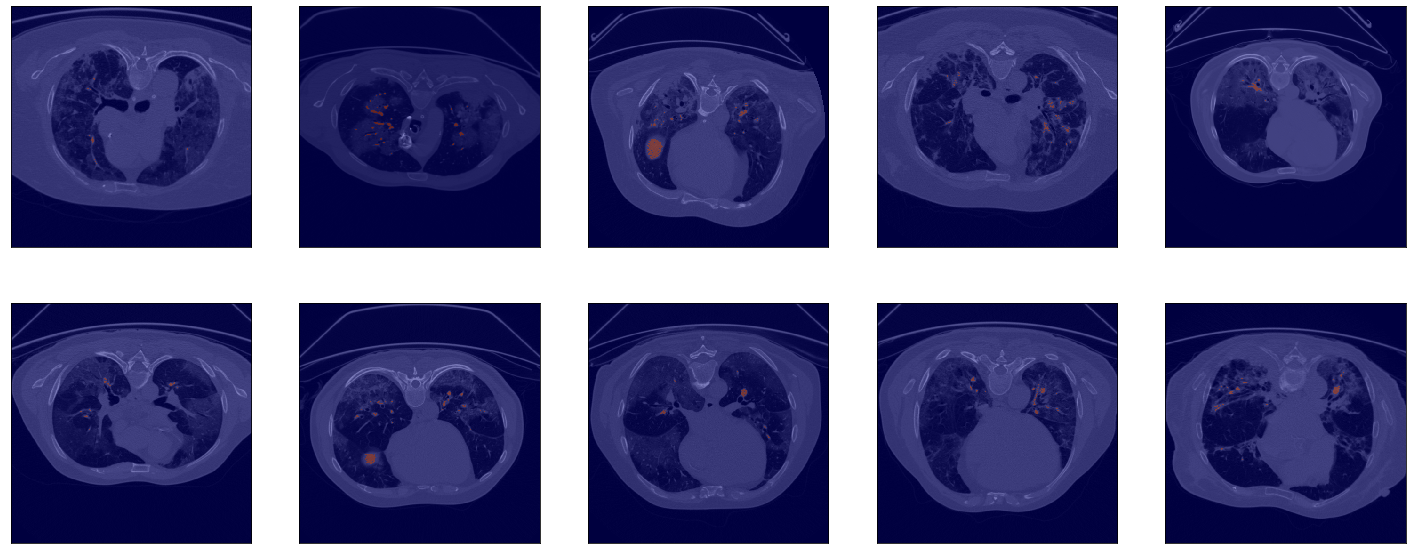

In [21]:
display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 13. Overlay - Covid
</b></center>'''))

fig, ax = plt.subplots(2, 5, figsize=(25,10))
ax = ax.flatten()

for i, filename in enumerate(covid_plotlist):
    img_name = filename
    
    ct_numpy = data_full.loc[data_full['image_id'] == filename, 'img'].iloc[0]
    ct_img = nib.Nifti1Image(ct_numpy, affine=np.eye(4))
    pixdim = find_pix_dim(ct_img)
    
    contours = intensity_seg(ct_numpy, min=-1000, max=-300)
    
    lungs = find_lungs(contours)
    lung_mask = create_mask_from_polygon(ct_numpy, lungs)
    
    lung_mask[lung_mask == 1] = 255
    lungs_img = nib.Nifti1Image(lung_mask, ct_img.affine)
    
    vessels_only = create_vessel_mask(lung_mask, ct_numpy, lungs, 
                                      denoise=True)

    ax[i].imshow(ct_numpy.T, 'gray', interpolation='none')
    ax[i].imshow(vessels_only.T, 'jet', interpolation='none', alpha=0.5)
    
    vessels_only[vessels_only == 1] = 255
    vessel_img = nib.Nifti1Image(vessels_only, ct_img.affine)
    
    ax[i].set_xticks([])
    ax[i].set_yticks([])

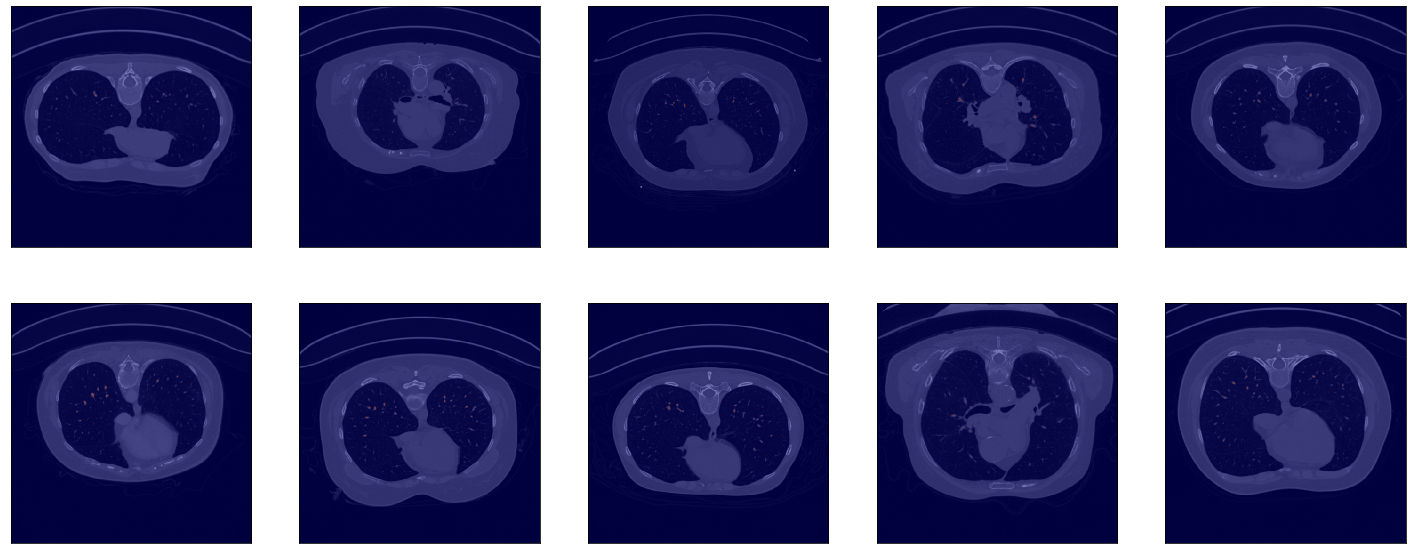

In [22]:
display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 14. Overlay - Normal
</b></center>'''))

fig, ax = plt.subplots(2, 5, figsize=(25,10))
ax = ax.flatten()

for i, filename in enumerate(clean_plotlist):
    img_name = filename
    
    ct_numpy = data_full.loc[data_full['image_id'] == filename, 'img'].iloc[0]
    ct_img = nib.Nifti1Image(ct_numpy, affine=np.eye(4))
    pixdim = find_pix_dim(ct_img)
    
    contours = intensity_seg(ct_numpy, min=-1000, max=-300)
    
    lungs = find_lungs(contours)
    lung_mask = create_mask_from_polygon(ct_numpy, lungs)
    
    lung_mask[lung_mask == 1] = 255
    lungs_img = nib.Nifti1Image(lung_mask, ct_img.affine)

    vessels_only = create_vessel_mask(lung_mask, ct_numpy, lungs, 
                                      denoise=True)

    ax[i].imshow(ct_numpy.T, 'gray', interpolation='none')
    ax[i].imshow(vessels_only.T, 'jet', interpolation='none', alpha=0.5)
    
    vessels_only[vessels_only == 1] = 255
    vessel_img = nib.Nifti1Image(vessels_only, ct_img.affine)
    
    ax[i].set_xticks([])
    ax[i].set_yticks([])

### C. Area Analysis 

<p style="text-align:justify">Using the computed masks for both the lungs and the vessels, we can now compute the correspoding area values by counting the 1 values of the binarized mask (or the pixel count) and multiplying it to the dimension of the CT image. This was done for the lung and vessels masks and a ration was done by dividing the vessel area with the lungs area.</p>

<p style="text-align:justify">The distribution range of the covid-positive area ratios is wider compared to those of healthy status. Most of the ratios for the healthy samples stay only up to 10%, and majority at 5% or below. Meanwhile covid-positive sample area ratios have higher values.</p>

In [23]:
master = pd.read_csv('master.csv')
covid = master[master['type'] == 2]
clean = master[master['type'] == 0]

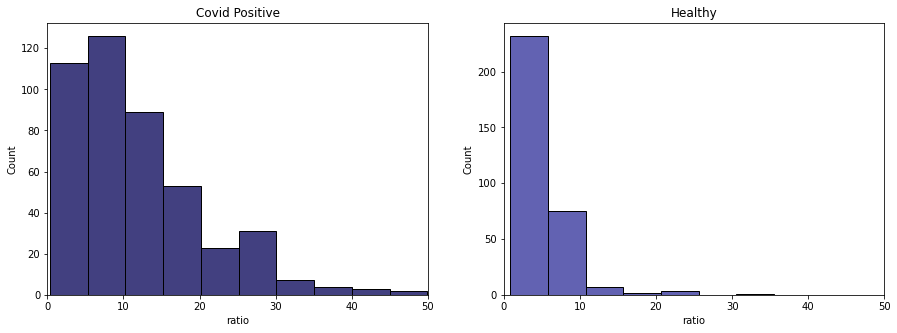

In [24]:
display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 15. Ratio Distribution for Covid-Positive & Healthy Samples
</b></center>'''))

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)

sns.histplot(covid['ratio'], ax=axes[0], bins=20, color=[COVID_COLORS[0]])
axes[0].set_title('Covid Positive')
axes[0].set_xlim(0,50)

sns.histplot(clean['ratio'], ax=axes[1], bins=20, color=[COVID_COLORS[1]])
axes[1].set_title('Healthy')
axes[1].set_xlim(0,50)

plt.show()

### D. Features Extraction

<p style="text-align:justify">A feature in an image can be in a structure such as points, edges, or objects. It can be classified into two main categories: keypoint features and edges. Keypoint features are often described by the appearance of patches of pixels surrounding a location, when applied to chest CT scan, this could be lesions that could be one of our major features in determining COVID-19. Meanwhile, edges can be good indicator of object boudaries such as the bones near the chest area which could be our region of interest. $^4$</p>

In [26]:
# load filtered data
with open('data/data_full_df.pkl', 'rb') as f:
    data_full = pickle.load(f)
    
# change covid type from 2 to 1
data_full.loc[data_full.type == 2, 'type'] = 1

# get sample covid and clean data
covid = data_full[data_full.type==1].copy()
clean = data_full[data_full.type==0].copy()

<p style="text-align:justify">Scale-Invariant Feature Transformation (SIFT) is one of feature detection and matching algorithm that is invariance to image scale and rotation. It has major advantages of locality, distinctiveness, quantity, efficiency, and extensibility. In this project, we used SIFT to detect features and match them to another image that belong to the same class and be able to detect similar patterns on the image and analyzed it. $^5$</p>

In [27]:
def plot_sift(img1, img2):
    """ Determine key points and perform feature matching between images
    
    Parameters
    ==========
    img1      :    np.ndarray
                   image 1
                   
    img2      :    np.ndarray
                   image 2               
    """
    fig = plt.figure(figsize=(10,8))
    grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)
    ax0 = plt.subplot(grid[0, 0])
    ax1 = plt.subplot(grid[0, 1])
    ax2 = plt.subplot(grid[1, 0:])

    sift = cv2.SIFT_create()         
    image8bit1 = cv2.normalize(img1, None, 0, 
                               255, cv2.NORM_MINMAX).astype('uint8')
    kp1, des1 = sift.detectAndCompute(image8bit1, None)

    
    img_sample1 = cv2.drawKeypoints(image8bit1, kp1, None)
    ax0.imshow(img_sample1);
    
    image8bit2 = cv2.normalize(img2, None, 0, 
                           255, cv2.NORM_MINMAX).astype('uint8')
    kp2, des2 = sift.detectAndCompute(image8bit2, None)
    img_sample2 = cv2.drawKeypoints(image8bit2, kp2, None)
    ax1.imshow(img_sample2);
    
    #feature matching
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

    matches = bf.match(des1,des2)
    matches = sorted(matches, key = lambda x:x.distance)

    img3 = cv2.drawMatches(image8bit1, kp1, image8bit2, kp2, matches[:50], 
                           image8bit2, flags=2)
    ax2.imshow(img3)

    plt.show()

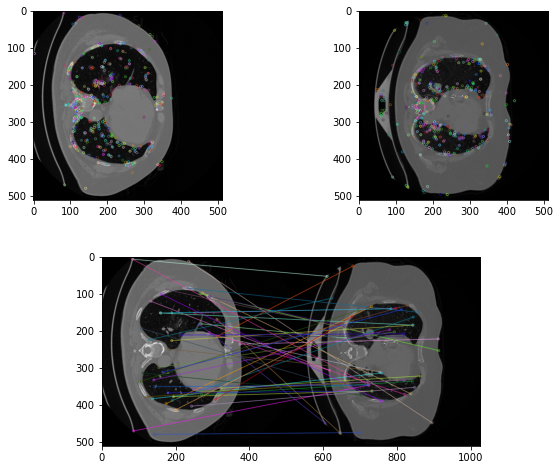

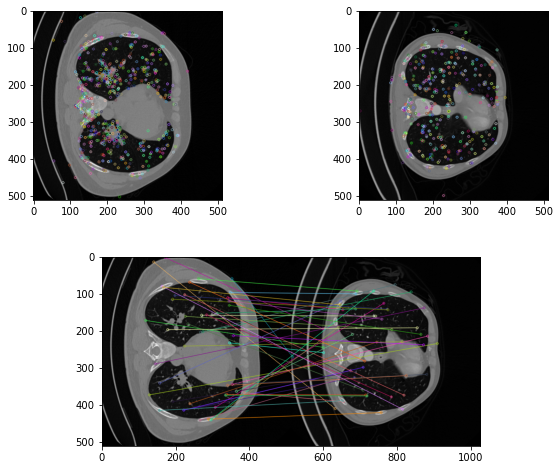

In [28]:
display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 16. Key feature points extraction from healthy and 
COVID-19 positive CT Scan
</b></center>'''))

display(HTML(f'''<h3 style="text-align:center">
                Key feature points of
                <b style="color:{COVID_COLORS[1]}">
                Covid-19</b> Positive CT-Scan
                </h3>'''))

plot_sift(covid.iloc[0]['img'], covid.iloc[1]['img'])

display(HTML(f'''<h3 style="text-align:center">
                 Key feature points of
                <b style="color:{COVID_COLORS[1]}">
                Healthy </b> CT-Scan
                </h3>'''))
plot_sift(clean.iloc[2]['img'], clean.iloc[1]['img'])

<p style="text-align:justify">It seems that there are more key feature and matched points found in healthy lungs. It might be because there are some lesions that are randomly formed in COVID-19 positive lungs which does not match easily with other lungs. </p>

### E. Classification of healthy and COVID-19 positive using Neural Network

<p style="text-align:justify">Image classification using Neural Network can also be done to classify COVID-19 positive based on the chest CT Scan of the patient. We can do this by first normalizing the image to have a value of 0 to 1 to avoid vanishing and exploding gradients.</p>

In [10]:
# normalize to min-max scaler
data_full['img'] = data_full.img.apply(lambda x: cv2.normalize(x, None, 0, 
                                       255, cv2.NORM_MINMAX).astype('uint8'))

# add new axis to indicate grayscale to be used in ml model 
data_full['img'] = [i[:,:, np.newaxis] for i in data_full.img]

We then split the data into 80% training and 20% validation set in order for us to properly evaluate our model.  

In [11]:
(X_train, X_test, 
 y_train, y_test) = train_test_split(np.asarray(data_full.img.to_list()), 
                                    data_full.type.to_numpy(), 
                                    test_size=0.2, 
                                    random_state=143,
                                    stratify=data_full.type.to_numpy())


<p style="text-align:justify">Since we only have small data we decided to use a basic convolutional network with 1 input channel and added a dropout to combat on overfitting. The summary of the model used can be seen in the figure below:</p>

In [1]:
inputs = tf.keras.Input(shape=(512, 512, 1))

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Flatten()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 510, 510, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 255, 255, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 253, 253, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 128)     73856     
_________________________________________________________________
dropout (Dropout)            (None, 124, 124, 128)     0     

<p style="text-align:justify">We set-up the loss function as <code>binary crossentropy</code> since we are just classifying whether a person has covid or not. We then set <code>adam</code> as optimizer because it brought us the best results, and <code>accuracy</code> as our metric since our data is not that imbalanced.</p>

In [ ]:
model.compile(loss='binary_crossentropy',
optimizer='adam',
metrics=['acc'])

<p style="text-align:justify">We fitted the model with 10 epochs since it is just a small dataset and it could possibly lead to overfitting if we increase it further. We also set the batch size of 32 to be able to run it on our resources. We then saved the trained model and the history of training for reusability and analysis.</p>

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test,
                                     y_test),
                    ) 

# save model
model.save('./models/cnn_ctscan.h5')

# save history
with open('./models/hist_ctscan.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [24]:
model = keras.models.load_model('models/cnn_ctscan.h5')
# load filtered data
with open('./models/hist_ctscan.pickle', 'rb') as f:
    history = pickle.load(f)
    
def plot_hist(hist):
    """Plot fitting history, specifically accuracy and loss.
    
    Parameters
    ===========
    hist       :    dict
                    history of the training of the model
    """
    sns.set_style('darkgrid')
    _, ax = plt.subplots(1, 2, figsize=(12, 5))
    temp_df = pd.DataFrame(hist)
    temp_df = temp_df.reset_index()
    temp_df.plot(
        x='index', y='val_acc', label='Validation Accuracy', ax=ax[0], 
        c='tab:green', style='--'
    )
    temp_df.plot.scatter(
        x='index', y='acc', label='Training Accuracy', ax=ax[0], c='tab:green'
    )

    ax[0].set_ylabel('Accuracy', fontsize=15)
    ax[0].set_xlabel('Epochs', fontsize=15)
    
    temp_df.plot(
        x='index', y='val_loss', label='Validation Loss', ax=ax[1], 
        c='tab:orange', style='--'
    )
    temp_df.plot.scatter(
        x='index', y='loss', label='Training Loss', ax=ax[1], c='tab:orange'
    )

    ax[1].set_ylabel('Loss', fontsize=15)
    ax[1].set_xlabel('Epochs', fontsize=15)
    
    plt.suptitle('Fitting History Plots', fontsize=20)
    plt.tight_layout()

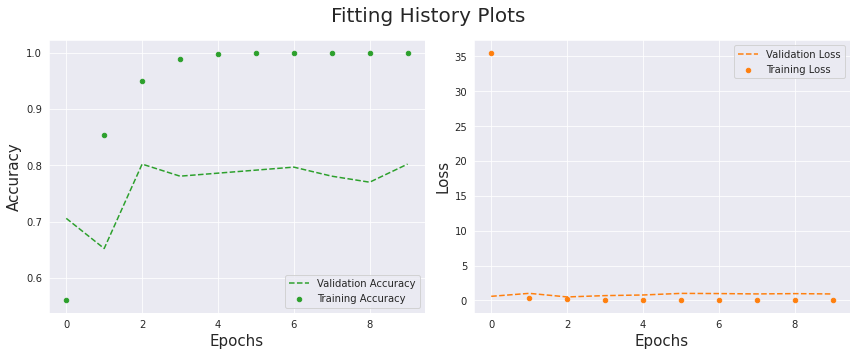

In [26]:
display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 17. Training History
</b></center>'''))
plot_hist(history)

<p style="text-align:justify">Our model was able to classify up to 80% of the validation set. However, it overfits the data as the training accuracy is already at 100% by 6th epoch. We recommend future researchers to use data augmentation techniques, change of architecture, and be able get more data to be able for the model to generalize data more effectively and get a better results.</p>

### F. Model Explainability

<p style="text-align:justify">We have created a machine learning model that was able to classify about 80% of the validation data, but equally important on creating a model that produces high accuracy is its explainability. Since we are dealing on medical data and health of a person could be on the line. Being able to understand on how the machine learning model works could help doctors in their decision making process.</p>

In [ ]:
# create a custom predict function to make it compatible with lime
def new_predict_fn(images):
    """ Create a custom predict function to make it compatible with lime
    
    Parameters
    ==========
    images     :    np.ndarray
                    image of size 4
                    
    Returns
    ========
    new_predict_fn    :  np.ndarray
                         predictions
    """
    return model.predict(images[:, :, :, 0])

def get_explanations(has_covid):
    """ Get explanations from lime image explainer
    
    Parameters
    ===========
    has_covid    :     int
                       1 for covid, 0 for healthy
    """
    explainer = lime_image.LimeImageExplainer()

    explanations = []
    clean_ind = np.where(y_test == has_covid)[0]
    for i in range(10, 20):
        ind = clean_ind[i]
        explanation = explainer.explain_instance(X_test[ind].reshape(512,512), 
                                                 new_predict_fn,  
                                                 hide_color=0, 
                                                 num_samples=50)

        explanations.append(explanation)
    return explanations

<p style="text-align:justify">We used Local Interpretable Model-Agnostic Explanations (lime) for our model explanation model. It explains the prediction of any classifier in an interpretable manner by learning a model locally around the prediction. It also supports input data as images and outputs a mask with green when it contributes positively which in case has a covid or red if it contributes negatively or healthy lungs.</p>

In [ ]:
clean_explanations = get_explanations(0)
covid_explanations = get_explanations(1)

In [29]:
def plot_explanations(explanations):
    """ Plot the explanations of lime
    
    Parameters
    ==========
    explanations    :   list
                        list of lime explanations
    """
    fig, ax = plt.subplots(2, 5, figsize=(15,6))
    ax = ax.flatten()

    for i in range(10):
        (temp, 
         mask) = (explanations[i]
                     .get_image_and_mask(explanations[i].top_labels[0], 
                                        positive_only=False, 
                                        num_features=10, 
                                        hide_rest=False))


        ax[i].imshow(mark_boundaries(temp, mask))
        ax[i].axis('off')
    plt.show()

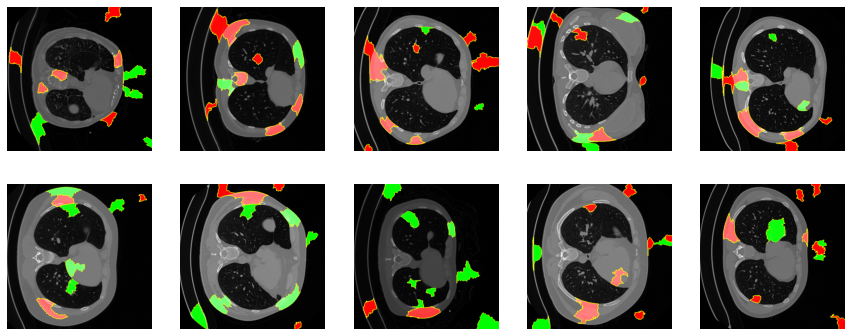

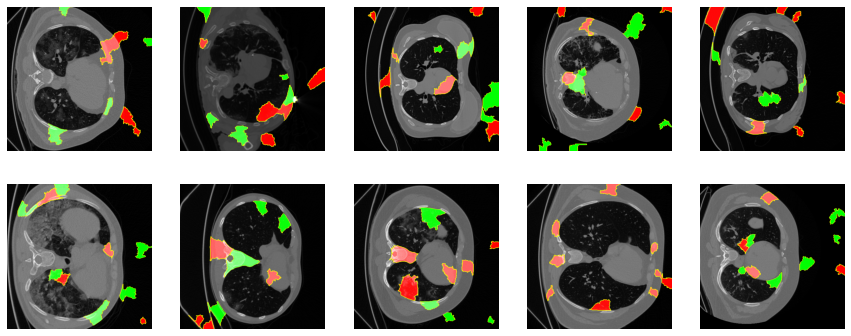

In [30]:
display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 18. Results of LIME model explainability
</b></center>'''))
with open('./models/covid_explanations.pickle', 'rb') as f:
    covid_explanations = pickle.load(f)
with open('./models/clean_explanations.pickle', 'rb') as f:
    clean_explanations = pickle.load(f)    

display(HTML(f'''<h3 style="text-align:center">
                Model explainability on
                <b style="color:{COVID_COLORS[1]}">
                Clean</b> CT-Scan
                </h3>''')) 
plot_explanations(clean_explanations)

display(HTML(f'''<h3 style="text-align:center">
                Model explainability on
                <b style="color:{COVID_COLORS[1]}">
                Covid-19</b> Positive CT-Scan
                </h3>''')) 

plot_explanations(covid_explanations)

<p style="text-align:justify">The results showed that the machine learning model produced some errors as it predicts parts outside the lungs to be indicative whether a person has covid or not which does not make any sense. However, we can observe that in both cases, the model is looking for spots inside the lungs identify a chest CT-Scan to be positive in COVID-19.</p>

<h2><font color='#030056'> VI. Conclusion </font></h2>

<p style="text-align:justify">In this technical report, we explore on more than a thousand CT-Scan file that are composed of more or less five hundred slices each. Among those data, majority of it are COVID-19 positive CT-Scan. We explored in using different filter in a CT-Scan file to see other information of the body such as tissues, bones, and organs. We then performed layer-by-layer analysis of a COVID-19 positive and a healthy CT-Scan, although it cannot be directly compared due to the structure of the body of a person, we can see that there are more lesions in a COVID-19 positive CT-Scan. We have also observed that there are 2 types of lungs which are open and closed.</p>

<p style="text-align:justify">Since there are not much information that we can get in the closed lungs, we filter all of the slices and retrieve only the image with the largest lung area visible for each of the more that a thousand CT-Scan files. We used AWS EMR clusters aided with PySpark to efficiently filter the images that have an overall file size of 200 GB. We then explore on the lesions overlay of the lungs via its classification and noted that lesions are indeed more visible in the COVID-19 positive CT-Scan. To verify, we performed area analysis to all of images with the largest lung are and compared the result of the COVID-19 positive and the healthy CT-Scans. We have also used feature detection and matching algorithm such as SIFT to determine the features of the images and found out that there more features matched in the healthy CT-scan. We also explored on using Neural Network to classify on the images and got a validation accuracy of 80% then we used LIME to interpret the results of the machine learning model. We saw that the model is looking for spots inside the lungs identify a chest CT-Scan to be positive in COVID-19.</p>

<h2><font color='#030056'> VII. Recommendations </font></h2>

<p style="text-align:justify">Image analysis using CT-Scan data is a growing field of research to identify several diseases. In this technical report, the researchers used image preprocessing, feature extraction, and machine learning model on CT-Scan file to perform descriptive and predictive analytics to classify COVID-19 positive. Future researcher can employ similar methodology to include other diseases in lungs. This can also be applied in other parts of the body such as identifying brain diseases.</p> 
<p style="text-align:justify">The Machine Learning model that the researchers used can still be imrpoved by changing its architecture design, data augmentation techniques on the dataset to increase the generalizability of the model, use more slices and filters of the CT-Scan to be able to gather more information of the organs, perform image segmentation first before using machine learning model to enhance the features that are important.</p>

<h2><font color='#030056'> References </font></h2>

[1] Kluge, H. (2020) "Statement – Older people are at highest risk from COVID-19, but all must act to prevent community spread". https://www.euro.who.int/en/health-topics/health-emergencies/coronavirus-covid-19/statements/statement-older-people-are-at-highest-risk-from-covid-19,-but-all-must-act-to-prevent-community-spread <br> <br> 
[2] Contou, D. (2021) "Causes and timing of death in critically ill COVID-19 patients". https://ccforum.biomedcentral.com/articles/10.1186/s13054-021-03492-x<br> <br> 
[3] Tomacruz, S. (2022) "GUIDE: Alert Level 1 rules as Philippines enters ‘new normal’" https://www.rappler.com/nation/guide-things-to-know-philippines-new-normal-alert-level-1/<br> <br> 
[4] Tiyagi, D. (2019) "Introduction To Feature Detection And Matching." https://medium.com/data-breach/introduction-to-feature-detection-and-matching-65e27179885d<br> <br> 
[5] Tiyagi, D. (2019) "Introduction to SIFT( Scale Invariant Feature Transform)" https://medium.com/data-breach/introduction-to-sift-scale-invariant-feature-transform-65d7f3a72d40<br><br>
[6] Adaloglou, N. (2021) "Introduction to medical image processing with Python: CT lung and vessel segmentation without labels." https://theaisummer.com/medical-image-python/#ct-intensities-and-hounsfield-units<br><br>